#### 1. Imports

In [1]:
import os
import json
from typing import Annotated, Sequence, TypedDict

from langchain_core.messages import (
    HumanMessage, AIMessage, BaseMessage, ToolMessage
)
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain.tools import tool
from langchain_tavily import TavilySearch
from langchain_openai import ChatOpenAI

from toolbox_langchain import ToolboxClient
from langgraph.graph import StateGraph, END
from langgraph.graph.message import add_messages

### 2. Async Load MCP Tools

In [2]:
mcp_client = ToolboxClient("http://127.0.0.1:5000")

async def load_mcp_tools():
    return await mcp_client.aload_toolset()

mcp_tools = await load_mcp_tools()
print("Loaded MCP tools:", [t.name for t in mcp_tools])

Loaded MCP tools: ['average-price-by-flat-type', 'count-hdb-flats-by-town', 'execute-sql-tool', 'list-hdb-flats-by-town', 'percentile-price-by-town', 'postgres-list-tables']


### 3. Shared Tools (Tavily & Amenities)


In [3]:
tavily = TavilySearch(max_results=5)

@tool
def search_hdb_amenities(query: str) -> str:
    """
    Search for amenities near an HDB block or town using Tavily.

    Example queries:
    - "amenities near Block 123 Ang Mo Kio"
    - "schools near Bukit Panjang"
    - "supermarkets near Tampines"
    - "parks near Woodlands"

    The tool returns summarized search results.
    """
    formatted_query = f"amenities around {query}, Singapore HDB, nearby facilities, schools, supermarkets, malls, transport"
    results = tavily.invoke(formatted_query)
    return results

### 4. Tool Registry

In [4]:
all_tools = mcp_tools + [tavily, search_hdb_amenities]
tools_by_name = {t.name: t for t in all_tools}
print("All tools:", list(tools_by_name.keys()))

All tools: ['average-price-by-flat-type', 'count-hdb-flats-by-town', 'execute-sql-tool', 'list-hdb-flats-by-town', 'percentile-price-by-town', 'postgres-list-tables', 'tavily_search', 'search_hdb_amenities']


### 5. Agent State

In [5]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

### 6. Define 3 Specialist Agents (SQL, Amenities, Web Search)

#### 6.1 SQL Agent Prompt

In [6]:
sql_prompt = ChatPromptTemplate.from_messages([
    ("system", """
SQL Agent.
You answer only questions requiring HDB resale data or stats.

Use MCP SQL tools ONLY.
Always return structured, correct SQL tool calls.

"""),
    MessagesPlaceholder("scratch_pad")
])

#### 6.2 Amenities Agent Prompt

In [7]:
amenities_prompt = ChatPromptTemplate.from_messages([
    ("system", """
Amenities Agent.
Use `search_hdb_amenities` first.
Use Tavily for deeper context.

You answer:
- amenities
- schools
- malls
- MRT
- supermarkets
near a block or town.
"""),
    MessagesPlaceholder("scratch_pad")
])

#### 6.3 Web Research Agent Prompt

In [8]:
web_prompt = ChatPromptTemplate.from_messages([
    ("system", """
Web Research Agent.
Use Tavily search for general knowledge or non-HDB topics.
"""),
    MessagesPlaceholder("scratch_pad")
])

### 7. Bind each model to its specialist prompt

In [9]:
MODEL = "moonshotai/kimi-k2-thinking"

def build_model():
    return ChatOpenAI(
        api_key=os.getenv("OPENROUTER_API_KEY"),
        base_url="https://openrouter.ai/api/v1",
        model=MODEL,
    )

sql_agent = sql_prompt | build_model().bind_tools(mcp_tools)
amenities_agent = amenities_prompt | build_model().bind_tools([search_hdb_amenities, tavily])
web_agent = web_prompt | build_model().bind_tools([tavily])

### 8. Supervisor Router

In [10]:
supervisor_prompt = ChatPromptTemplate.from_messages([
    ("system", """
You are the Supervisor.

ROUTE the user query to one agent:
- SQL_AGENT for resale/transaction/statistics queries
- AMENITIES_AGENT for amenities/schools/MRT/malls
- WEB_AGENT for general queries

Respond with ONLY one of:
SQL_AGENT
AMENITIES_AGENT
WEB_AGENT
"""),
    MessagesPlaceholder("messages")
])

router_model = build_model()

### 9. Supervisor Node

In [12]:
async def router_node(state: AgentState):
    decision = await router_model.ainvoke(
        supervisor_prompt.format(messages=state["messages"])
    )

    route = decision.content.strip().upper()

    if route not in {"SQL_AGENT", "AMENITIES_AGENT", "WEB_AGENT"}:
        route = "WEB_AGENT"     # fallback so KeyError never happens

    return {"next_agent": route}

### 10. Shared Tool Node (Async)

In [13]:
async def tool_node(state: AgentState):
    last = state["messages"][-1]
    outputs = []

    for tc in last.tool_calls:
        tool = tools_by_name[tc["name"]]
        result = await tool.ainvoke(tc["args"])
        
        outputs.append(ToolMessage(
            content=json.dumps(result),
            name=tc["name"],
            tool_call_id=tc["id"],
        ))

    return {"messages": outputs}

### 11. Generic model execution wrapper

In [14]:
async def run_agent(agent, state):
    response = await agent.ainvoke({"scratch_pad": state["messages"]})
    return {"messages": [response]}

### 12. Full Multi-Agent Graph

In [15]:
# Specialist agent wrappers
async def sql_agent_node(state):
    return await run_agent(sql_agent, state)

async def amenities_agent_node(state):
    return await run_agent(amenities_agent, state)

async def web_agent_node(state):
    return await run_agent(web_agent, state)

workflow = StateGraph(AgentState, async_mode=True)

# Register nodes
workflow.add_node("ROUTER", router_node)
workflow.add_node("SQL_AGENT", sql_agent_node)
workflow.add_node("AMENITIES_AGENT", amenities_agent_node)
workflow.add_node("WEB_AGENT", web_agent_node)
workflow.add_node("TOOLS", tool_node)

# Each agent → decide continue or end
def next_step(state: AgentState):
    last = state["messages"][-1]
    return "TOOLS" if last.tool_calls else END

workflow.add_conditional_edges("SQL_AGENT", next_step, {"TOOLS": "TOOLS", END: END})
workflow.add_conditional_edges("AMENITIES_AGENT", next_step, {"TOOLS": "TOOLS", END: END})
workflow.add_conditional_edges("WEB_AGENT", next_step, {"TOOLS": "TOOLS", END: END})


# Supervisor decides next hop
workflow.add_conditional_edges(
    "ROUTER",
    lambda out: out["next_agent"],
    {
        "SQL_AGENT": "SQL_AGENT",
        "AMENITIES_AGENT": "AMENITIES_AGENT",
        "WEB_AGENT": "WEB_AGENT",
    },
)

workflow.add_edge("TOOLS", "ROUTER")
workflow.set_entry_point("ROUTER")

graph = workflow.compile()

Display Mermaid Diagram

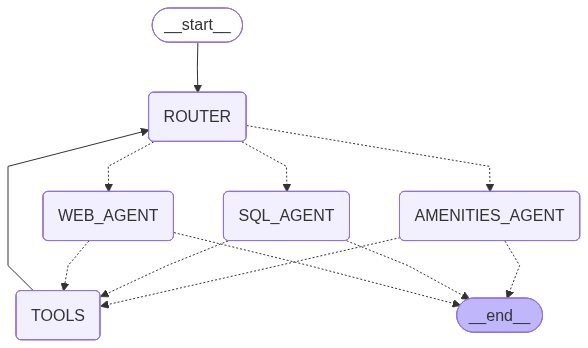

In [16]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

### 13. Examples — MAS in Action

#### Amenities Example

In [17]:
inputs = {
    "messages": [
        HumanMessage("What amenities are near Block 110 in Toa Payoh?")
    ]
}

async for step in graph.astream(inputs, stream_mode="values"):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

What amenities are near Block 110 in Toa Payoh?
================================== Ai Message ==================================
Tool Calls:
  search_hdb_amenities ( functions.search_hdb_amenities:0)
 Call ID:  functions.search_hdb_amenities:0
  Args:
    query: amenities near Block 110 Toa Payoh
================================= Tool Message =================================
Name: search_hdb_amenities

{"query": "amenities around amenities near Block 110 Toa Payoh, Singapore HDB, nearby facilities, schools, supermarkets, malls, transport", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.singaporeunited.sg/explore-modern-living-in-singapores-iconic-toa-payoh-lorong-1-toa-payoh-condo-near-shopping-centres-and-hdb-hub/", "title": "Explore Modern Living in Singapore's Iconic Toa Payoh", "content": "It is located near several shopping centres and HDB Hub, offering u

#### Resale Price (Median) Example

In [19]:
async for step in graph.astream(
    {"messages": [HumanMessage("Show me the median resale price of 4-room flats in Bishan.")]},
    stream_mode="values"
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Show me the median resale price of 4-room flats in Bishan.
================================== Ai Message ==================================
Tool Calls:
  postgres-list-tables ( functions.postgres-list-tables:0)
 Call ID:  functions.postgres-list-tables:0
  Args:
    output_format: detailed
================================= Tool Message =================================
Name: postgres-list-tables

"[{\"object_details\":{\"columns\":[{\"column_comment\":null,\"column_default\":null,\"column_name\":\"month\",\"data_type\":\"text\",\"is_not_nullable\":false,\"ordinal_position\":1},{\"column_comment\":null,\"column_default\":null,\"column_name\":\"town\",\"data_type\":\"text\",\"is_not_nullable\":false,\"ordinal_position\":2},{\"column_comment\":null,\"column_default\":null,\"column_name\":\"flat_type\",\"data_type\":\"text\",\"is_not_nullable\":false,\"ordinal_position\":3},{\"column_comment\":null,\"column_d